In [39]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

In [40]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_absolute_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_relative_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [41]:
'''Set sample names as index and shuffle data'''
index = target.Lake[target.Lake == 'Muskegon'].index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [45]:
hna_scores = pd.read_csv('Scores/hnascores_otus_5seq10_rel_Muskegon.csv', index_col=0)
''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [46]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [57]:
kendall_abs = np.zeros(hna_scores.shape[0])
p_kendall_abs = np.zeros(hna_scores.shape[0])
kendall_rel = np.zeros(hna_scores.shape[0])
p_kendall_rel = np.zeros(hna_scores.shape[0])
kendall_clr = np.zeros(hna_scores.shape[0])
p_kendall_clr = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    kendall_abs[i], p_kendall_abs[i] = kendalltau(data_abs.loc[index_prod,otu],prod)
    kendall_rel[i], p_kendall_rel[i] = kendalltau(data_rel.loc[index_prod,otu],prod)
    kendall_clr[i], p_kendall_clr[i] = kendalltau(data_rel_clr.loc[index_prod,otu],prod)
    i+=1
    
hna_scores['kendall_prod_abs'] = kendall_abs
hna_scores['p_kendall_prod_abs'] = p_kendall_abs
hna_scores['kendall_prod_rel'] = kendall_rel
hna_scores['p_kendall_prod_rel'] = p_kendall_rel
hna_scores['kendall_prod_clr'] = kendall_clr
hna_scores['p_kendall_prod_clr'] = p_kendall_clr

In [58]:
display(hna_scores.head(10))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall,kendall_prod_abs,p_kendall_prod_abs,kendall_prod_clr,p_kendall_prod_clr,kendall_prod_rel,p_kendall_prod_rel
Otu000029,0.618,61707.245500,1.200677,0.008522,0.878843,0.259651,2.860222e-03,-0.073684,0.649671,-0.115789,0.475367,-0.148150,0.363140
Otu000173,0.588,19183.863568,1.389539,0.002640,1.213961,0.501851,8.199569e-09,0.284211,0.079775,0.284211,0.079775,0.273507,0.096638
Otu000038,0.554,51754.310417,1.307713,0.006845,1.065805,0.279746,1.312698e-03,0.073684,0.649671,-0.042105,0.795208,-0.063493,0.696727
Otu000242,0.506,4279.004838,1.331277,0.000632,1.054300,0.195135,2.500431e-02,0.226914,0.162763,0.063158,0.697031,0.099062,0.569147
Otu000088,0.506,7070.539859,1.127830,0.001325,1.105117,-0.240613,5.714879e-03,0.237468,0.144081,0.168421,0.299169,0.128353,0.447041
Otu000487,0.498,4687.135556,1.295638,0.000794,1.225094,-0.207827,1.698122e-02,-0.310200,0.058703,-0.400000,0.013672,-0.382802,0.023236
Otu000264,0.482,3122.072440,1.997179,0.000517,1.921987,0.278689,1.369320e-03,0.334529,0.044506,0.305263,0.059867,0.322022,0.067135
Otu000614,0.476,1641.008636,1.355790,0.000255,1.430488,0.278689,1.369320e-03,0.468293,0.007431,0.442105,0.006424,0.429988,0.017191
Otu001267,0.434,1248.439540,2.161542,0.000151,2.083781,0.286092,1.015928e-03,0.260599,0.140728,0.242105,0.135585,0.261574,0.148243
Otu000244,0.430,5221.455116,2.520187,0.001433,2.554319,-0.455315,1.697078e-07,-0.260133,0.160363,-0.231579,0.153422,-0.246335,0.189135


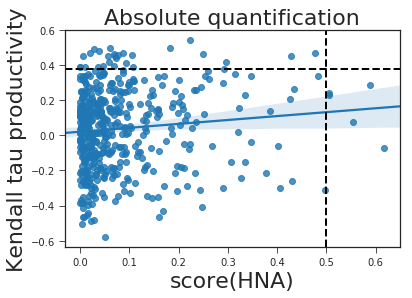

In [59]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_abs'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

In [60]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_abs'] > 0.377)].index

In [67]:
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_abs.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Absolute abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

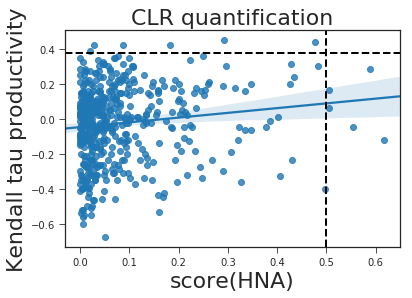

In [62]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_clr'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()

In [64]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_clr'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

In [66]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_rel'] > 0.377)].index

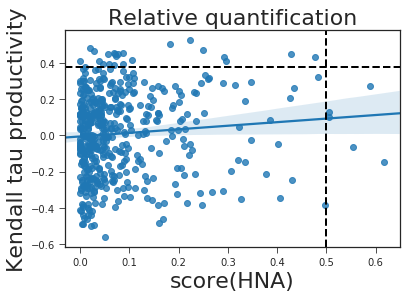

In [65]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_rel'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()